# Bayesian Inference and the pyVBRc

This notebook works through a slightly simplified version of the Bayesian Inference analysis from Havlin et al. 2021, which relied on a pure matlab implementation. 


## Overview of Bayesian Inference

The principle behind a Bayesian Inference is that existing knowledge of a process (the prior distribution) can be used together with how well a prediction explains an observation (the likelihood) to calculate the overall probability that a process explains an observation (the posterior distribution).

In mathematical terms, 

$$ P(x | y) = \frac{P(y | x) P(x)}{p_o} \;\;\;\;\;\;\;\;\;\;(1)$$

Where $x$ is some variable that might explain an observation $y$. The different terms are:

* $P(x)$: the prior distribution of variable x, or how likely it is for a value x to appear
* $P(y | x)$: the likelihood, or how well a value of x can explain the observation y
* $p_o$: the marginal likelihood of the observation (this is typically taken as a constant, see [here](https://en.wikipedia.org/wiki/Bayesian_inference) for more info).
* $P(x |y)$: the posterior distribution

In terms of our seismological questions, we want to know for of given observations of attenuation, $Q^{-1}$, and shear wave velocity, $V_s$, what is the likely thermodynamic state? In the following, we'll work with quality factor, $Q$, rather than attenuation. Rewriting equation 1 in terms of our observations and thermodynamic state, $S$: 

$$P( S | Q, V_s) = \frac{P( Q, V_s | S) P(S)}{p_o} \;\;\;\;\;\;\;\;\;(2)$$


Furthermore, our observations of $Q$ and $V_s$ are independent, in which case we can write our likelihood as the joint likelihood of the two separate observations:

$$P( S | Q, V_s) = \frac{P( Q |S ) P( V_s | S) P(S)}{p_o} \;\;\;\;\;\;\;\;\;(3)$$

Finally, for our thermodynamic state, we will vary temperature: $T$, grain size: $d$ and melt fraction: $\phi$ while fixing the remaining variables (pressure, density, etc.), in which case. We will again treat these variables as independent, in which case the join distribution is again the product the distributions for each:

$$P( T, d, \phi | Q, V_s) = \prod_{x \in T,d,\phi} P( Q | x) P( V_s | x) P(x) ) / p_o \;\;\;\;\;\;\;\;\;(4)$$

So in the following notebook we will calculate a posterior distribution in 3 steps:

1. define our prior distributions, P(T), P(dg_m), P(phi) using some functionality from the scipy package
2. build a fucntion for calculating the likelihood that relies on pyVBRc to calculate predicted Q and Vs from T, dg_m, phi
3. calculate and plot the final posterior distribution

Note that the analysis differs slightly from that in Havlin et al., 2021, and so the final result does differ slightly. Also note, that from here on, we'll be dropping the $p_o$ constant, and so results reflect a proportionality rather than an absolute relationship. 


## Prior Distributions

So to get started, we're going to use the `scipy.stats` to describe the prior model distributions for grain size, melt and temperature. 

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

### grain size 

For grain size, we will assume a log-normal grain size with a mean value of 1 mm and standard deviation of log(sigma) = 0.25. For this, we can use the `scipy.stats.lognorm` class:

In [2]:
log_sigma = 0.25 
mean_grain_size = 0.001
grain_size_dist = stats.lognorm(log_sigma, scale=mean_grain_size)

We can visualize our distribution by pulling some random samples uing the `rvs` method. In the following, we extract 10,000 samples and plot two histograms, one with a linear scale on the x-axis and one with a log scale. We also plot some scaled continuous probability distributions:

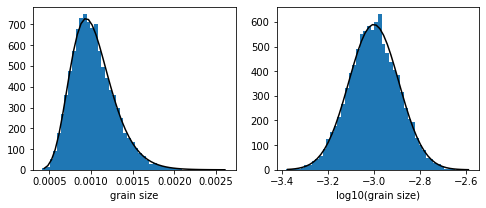

In [3]:
samples = grain_size_dist.rvs(size=10000)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
counts, bin_edges, ignored = axs[0].hist(samples, histtype="stepfilled", bins = 50)
axs[0].set_xlabel("grain size")
x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = grain_size_dist.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
axs[0].plot(x, pdf_scaled,'k')

counts, bin_edges, ignored = axs[1].hist(np.log10(samples), histtype="stepfilled", bins = 50)
x_edges = 10**bin_edges
x = (x_edges[1:] + x_edges[0:-1])/2.
xpdf = grain_size_dist.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(x_edges))
axs[1].plot(np.log10(x), pdf_scaled,'k')
_ = axs[1].set_xlabel("log10(grain size)")

Note that since we're using a log-normal distribution, the distribution appears skewed when using the linear axis and appears gaussian when usings the log axis. 

### melt fraction

For melt fraction, we'll use a uniform distribution between 0 and 0.05. When initializing the `scipy.stats.uniform` distribution, we must provide the min value and the change in the value:

In [4]:
min_melt_fraction = 0
melt_fraction_delta = 0.05 

melt_fraction_dist = stats.uniform(min_melt_fraction, melt_fraction_delta)

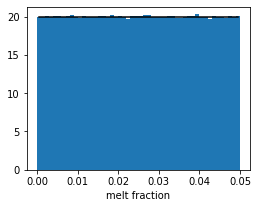

In [5]:
samples = melt_fraction_dist.rvs(size=1000000)

f, axs = plt.subplots(1, figsize=(4,3))
counts, bin_edges, ignored = axs.hist(samples, histtype="stepfilled", density=True, bins = 50)
axs.set_xlabel("melt fraction")

x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = melt_fraction_dist.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
_ = axs.plot(x, pdf_scaled,'k')

## temperature

And finally for temperature, we'll also use a uniform distribution between 1100 and 1800 C:

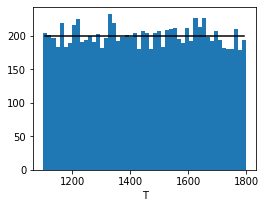

In [6]:
Tmin = 1100
dT = 700

T_dist_C = stats.uniform(Tmin, dT)
samples = T_dist_C.rvs(size=10000)

f, axs = plt.subplots(1, figsize=(4,3))
counts, bin_edges, ignored = axs.hist(samples, histtype="stepfilled", density=False, bins = 50)
x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = T_dist_C.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
axs.plot(x,pdf_scaled ,'k')
_ = axs.set_xlabel("T")

## Calculating the Likelihood

To calculate how well a predicted value explains an observations, we need 3 components:

1. the observations we are trying to explain
2. a way to compute predicted values 
3. an implementation of the likelihood function 

### Observations

For this example, we will take the Q and Vs values for the Basin and Range from Havlin et al 2021. These values are extracted using a sampling and averaging procedure (described in Havlin et al) using the $Q$ data from Dalton & Ekstrom 2008 and the $V_s$ data from Shen and Ritzwoller 2016. The following values and standard deviations are extracted from around 3 GPa and represent averages over some of the Basin and Range:

In [7]:
Q = 54.  # from B&R
std_Q = 10.
Vs = 4.12 * 1e3 # from B&R
std_Vs = 0.05 * 1e3
(Q, Vs)

(54.0, 4120.0)

We treat our observations as normal distributions, and while not needed for the analysis below, we can also visualize these distributions:

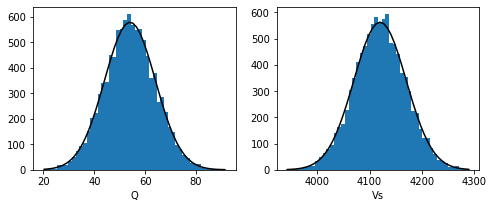

In [8]:
Qdist = stats.norm(Q, scale=std_Q)
Qsamples = Qdist.rvs(size=10000)

Vsdist = stats.norm(Vs, scale=std_Vs)
Vsamples = Vsdist.rvs(size=10000)
xpdf = T_dist_C.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
counts, bin_edges, ignored = axs[0].hist(Qsamples, histtype="stepfilled", bins = 50)
axs[0].set_xlabel("Q")
x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = Qdist.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
axs[0].plot(x, pdf_scaled,'k')


counts, bin_edges, ignored = axs[1].hist(Vsamples, histtype="stepfilled", bins = 50)
axs[1].set_xlabel("Vs")
x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = Vsdist.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
_ = axs[1].plot(x, pdf_scaled,'k')

## Predicting Values (with the VBRc)

Next, we need to be able to calculate predicted values for our Q and Vs obversations from a set of T, dg, and phi values. To do this, we'll rely on a pyVBRc interpolator. We will load in a `.mat` file (which can be generated using `ex_003_vbr_bayes_generate_vbr.m` in this directory). So let's load the `.mat` file first and initialize interpolators for `Vs` and `Q`:

In [9]:
from pyVBRc.vbrc_structure import VBRCstruct

In [10]:
vbr = VBRCstruct('./VBRc_sample_LUT.mat', lut_dimensions=["T_K", "phi", "dg_um"])
vbr.input.SV.f

array([0.01, 0.1 ])

In [11]:
V_interp = vbr.interpolator(('anelastic', 'andrade_psp', 'V'), 0, log_vars=['dg_um'])
Q_interp = vbr.interpolator(('anelastic', 'andrade_psp', 'Q'), 0, log_vars=['dg_um'])
vbr.lut_dimensions

['T_K', 'phi', 'dg_um']

Note that here we have started to diverge from Havlin et al a bit. We will be comparing for a single frequency and pressure value, whereas Havlin et al rely on some averaging over frequency and depth/pressure ranges.

remember that to use our interpolater, we need to provide values for each of our look-up table dimensions in the typical units expected by the VBRc, accounting for logginess for any variables we noted in the `log_vars` list when initializing the interpolators:

In [12]:
sample_dg_um = np.log10(0.01 * 1e6)
sample_T_K = 1200 + 273
sample_phi = 0.01
Vs_pred = V_interp((sample_T_K, sample_phi, sample_dg_um))
Q_pred = Q_interp((sample_T_K, sample_phi, sample_dg_um))

Q_pred, Vs_pred

(array(157.86649135), array(4339.44180979))

## Likelihood

So now we have our observations and we have a way of predicting Vs and Q for a given set of T, dg_m and phi, so now we need a way to calculate the likelihood, P(Vs, Q | T, dg_m, phi). 

For a given T, phi, dg_m, we need to calculate predicted values and then calculate the probability that those predicted values are in the distribution of observed values. Following Havlin et al., 2021 we treat our observations as normal distributions, in which case we can construct a function to take a given T, phi, grain size and return a likelihood:

In [13]:
def Q_likeli(Q_pred):
    return 1./(std_Q * np.sqrt(2*np.pi)) * np.exp( - 0.5 * ((Q_pred - Q)/std_Q)**2)

def Vs_likeli(V_pred):
    return 1./(std_Vs * np.sqrt(2*np.pi)) * np.exp( - 0.5 * ((V_pred - Vs)/std_Vs)**2)

def likelihood(T, phi, dg_m):
    
    dg_um = dg_m * 1e6
    Vs_pred = V_interp((T+273, phi, np.log10(dg_um)))
    Q_pred = Q_interp((T+273, phi, np.log10(dg_um)))
    
    P_Q = Q_likeli(Q_pred)
    P_Vs = Vs_likeli(Vs_pred)
    return P_Q * P_Vs
        

This function works with single values:

In [14]:
likelihood(1200, 0.001, 0.004)

1.505128917262989e-22

or with 1D arrays of values:

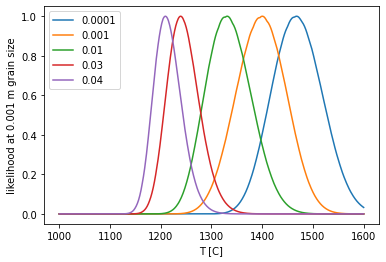

In [15]:
Ttest = np.linspace(1000, 1600, 500)  # degree C
dgtest = np.full(Ttest.shape, 0.001)
for phival in [0.0001, 0.001, 0.01, 0.03, 0.04]:    
    phitest = np.full(Ttest.shape,phival)    
    L = likelihood(Ttest, phitest, dgtest)
    plt.plot(Ttest, L/L.max(), label=f"{phival}")
plt.xlabel("T [C]")
plt.ylabel("likelihood at 0.001 m grain size")
plt.legend()

To use with multi-dimensional grids, we'll need to flatten and then un-flatten:

In [16]:
Ttest = np.linspace(1100, 1600, 45)  # degree C
phitest = np.linspace(0, 0.05, 50) 
dgtest = np.logspace(-4, -2, 35)

Tg, phig, dgg = np.meshgrid(Ttest, phitest, dgtest, indexing='ij')

P = likelihood(Tg.flatten(), phig.flatten(), dgg.flatten())
P = P.reshape(Tg.shape)
P.shape

(45, 50, 35)

Plotting the likelihood at a single grain size value:

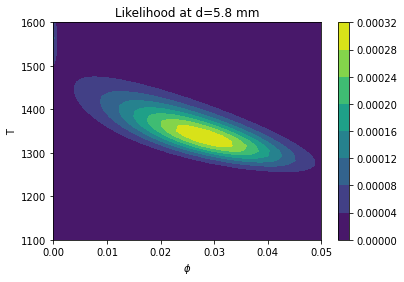

In [17]:
plt.contourf(phitest, Ttest, P[:,:, 30])
plt.xlabel("$\phi$")
plt.ylabel("T")
plt.title(f"Likelihood at d={int(dgtest[30]*10000)/10000 * 1000.} mm")
_ = plt.colorbar()

Or we can plot the marginal likelihood by summing over one of the axes, here grain size:

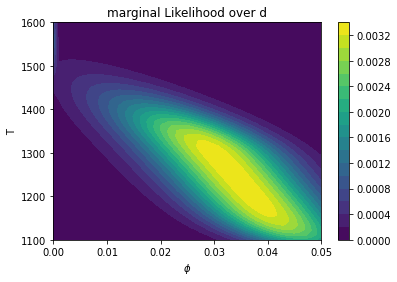

In [18]:
plt.contourf(phitest, Ttest, P.sum(axis=2), levels=20)
plt.xlabel("$\phi$")
plt.ylabel("T")
plt.title(f"marginal Likelihood over d")
_ = plt.colorbar()

## The posterior distribution

The above plots are just likelihoods. For a full bayes inference, we want to multiply by our prior distributions to get our posterior distribution. So let's extract our prior model pdf's from our scipy.stats distributiosn:

In [19]:
P_T = T_dist_C.pdf(Tg)
P_phi = melt_fraction_dist.pdf(phig)
P_dgg = grain_size_dist.pdf(dgg)
P_T.shape

(45, 50, 35)

and calculation our final posterior:

In [20]:
Posterior = P * P_T * P_phi * P_dgg

To plot our 3D distribution in 2D, we'll want to plot our marginal probabilities by summing over the axis not plotted:

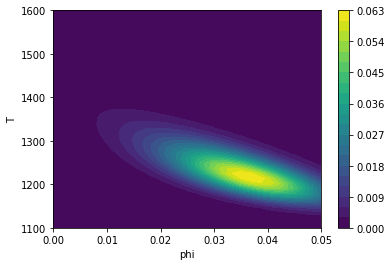

In [21]:
plt.contourf(phitest, Ttest, Posterior.sum(axis=2), levels=20)
plt.xlabel("phi")
plt.ylabel("T")
_ = plt.colorbar()

and furthermore, we can plot the marginal probability of the axis not being plotted by summing over the other two:

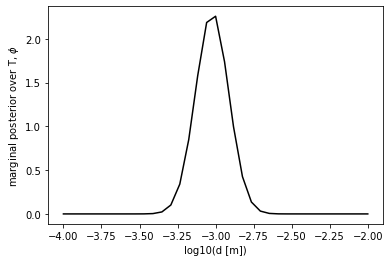

In [22]:
plt.plot(np.log10(dgtest), Posterior.sum(axis=1).sum(axis=0), 'k')
plt.xlabel("log10(d [m])")
_= plt.ylabel("marginal posterior over T, $\phi$")

repeating for the other combinations of axes:

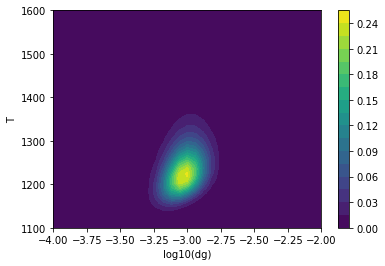

In [23]:
plt.contourf(np.log10(dgtest), Ttest, Posterior.sum(axis=1), levels=20)
plt.xlabel("log10(dg)")
plt.ylabel("T")
plt.colorbar()

Text(0, 0.5, 'marginal posterior over T, d')

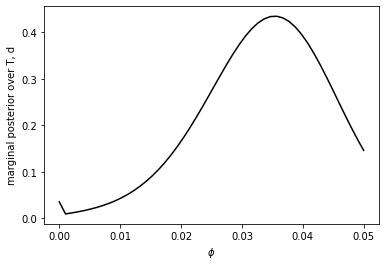

In [24]:
plt.plot(phitest, Posterior.sum(axis=2).sum(axis=0), 'k')
plt.xlabel("$\phi$")
plt.ylabel("marginal posterior over T, d")

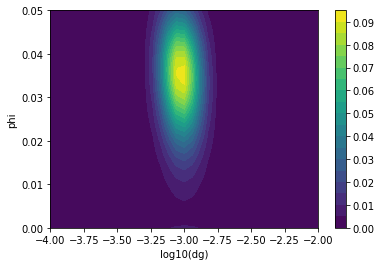

In [25]:
plt.contourf(np.log10(dgtest), phitest, Posterior.sum(axis=0), levels=20)
plt.xlabel("log10(dg)")
plt.ylabel("phi")
plt.colorbar()

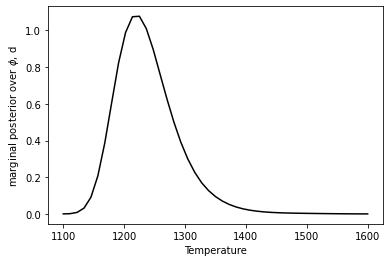

In [26]:
plt.plot(Ttest, Posterior.sum(axis=2).sum(axis=1), 'k')
plt.xlabel("Temperature")
_ = plt.ylabel("marginal posterior over $\phi$, d")

Note that there are small differences from Havlin et al., 2021 figure 10 because we are doing this at a single frequency rather than averaging over frequencies. 

## temperature: a normal distribution

As a final extra demo, let's say we want to change one of prior models. For example, if we have a tighter constraint on possible temperatures, how does that change our inference? 

Let's say we have some petrological constraints from xenoliths that place the temperature around 1400C. To test how this may influence our inferred ranges, let's choose a tightly constrained normal distribution as our temperature prior model:

Text(0.5, 0, 'T')

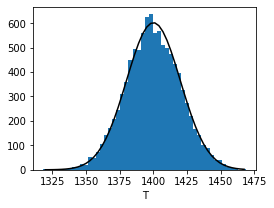

In [27]:
mean_T = 1400
sig_T = 20

T_dist_C = stats.norm(mean_T, sig_T)

samples = T_dist_C.rvs(size=10000)

f, axs = plt.subplots(1, figsize=(4,3))
counts, bin_edges, ignored = axs.hist(samples, histtype="stepfilled", density=False, bins = 50)
x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = T_dist_C.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
axs.plot(x,pdf_scaled ,'k')
axs.set_xlabel("T")

Because the prior model does not change the likelihood function, we can just re-compute our discrete prior model and re-calculate the posterior with:

In [28]:
P_T = T_dist_C.pdf(Tg)
Posterior = P * P_T * P_phi * P_dgg

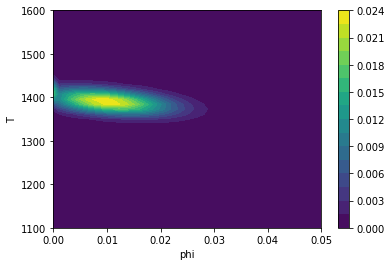

In [29]:
plt.contourf(phitest, Ttest, Posterior.sum(axis=2), levels=20)
plt.xlabel("phi")
plt.ylabel("T")
plt.colorbar()

## Further exploration

Some questions to explore on your own:

* what happens with a larger range in possible grain size?
* how does the frequency that we use for calculating predicted values affect the posterior distribution? 

## References

Havlin, Holtzmann and Hopper (2021).Inference of thermodynamic state in the asthenosphere from anelastic properties, with applications to North American upper mantle. Physics of the Earth and Planetary Interiors, 314, 106639, https://doi.org/10.1016/j.pepi.2020.106639

Dalton, C. A., Ekström, G., & Dziewoński, A. M. (2008). The global attenuation structure of the upper mantle. Journal of Geophysical Research: Solid Earth, 113(B9). https://doi.org/10.1029/2007JB005429

Shen, W., & Ritzwoller, M. H. (2016). Crustal and uppermost mantle structure beneath the United States. Journal of Geophysical Research: Solid Earth, 121(6), 4306-4342. https://doi.org/10.1002/2016JB012887 
